In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_hourly_stationary.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP_diff
READ_DATE,
2019-01-01 00:00:00,0.001403
2019-01-01 01:00:00,0.005698
2019-01-01 02:00:00,-0.001508
2019-01-01 03:00:00,-0.150329
2019-01-01 04:00:00,-0.190913
...,...
2024-05-31 19:00:00,-0.062767
2024-05-31 20:00:00,0.315028
2024-05-31 21:00:00,0.868913


In [4]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [6]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train, train['KWH_EXP_diff'], time_steps)
X_test, y_test = create_dataset(test, test['KWH_EXP_diff'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(34968, 96, 1) (34968,)
(12312, 96, 1) (12312,)


In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 96, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)


SPLITTING DATA RATIO :

* Train data : tahun 2019-2022 akhir
* Test data : tahun 2023-ujung data
* Validation data : diambil 10% dari training data

In [9]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 3.2838 - val_loss: 1.5307 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.7752 - val_loss: 1.5080 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.6504 - val_loss: 1.4942 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.5913 - val_loss: 1.4684 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.5181 - val_loss: 1.4318 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.4700 - val_loss: 1.4218 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.4263 - val_loss: 1.4197 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.3839 - val_loss: 1.3960 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.3765 - val_loss: 1.3993 - learning_rate: 6.703

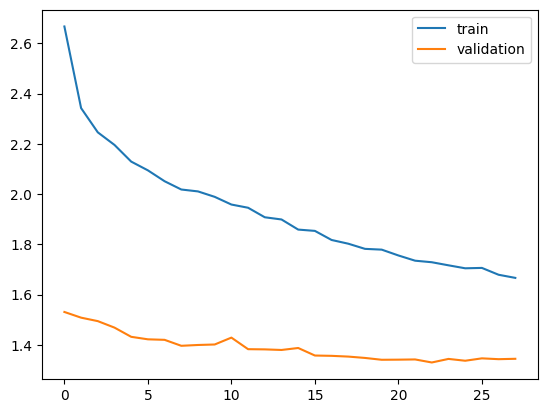

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [11]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [12]:
# load data awal agar dapat dikembalikan lagi ke nilai awal
df2 = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_standard.csv')
df2['READ_DATE'] = pd.to_datetime(df2['READ_DATE'])
df2.set_index('READ_DATE', inplace=True)
df2

,KWH_EXP
READ_DATE,
2019-01-01 00:00:00,2.334143
2019-01-01 00:15:00,2.344050
2019-01-01 00:30:00,2.500311
2019-01-01 00:45:00,2.432096
2019-01-01 01:00:00,2.388465
...,...
2024-05-31 21:45:00,68.226236
2024-05-31 22:00:00,69.132420
2024-05-31 23:15:00,68.774401


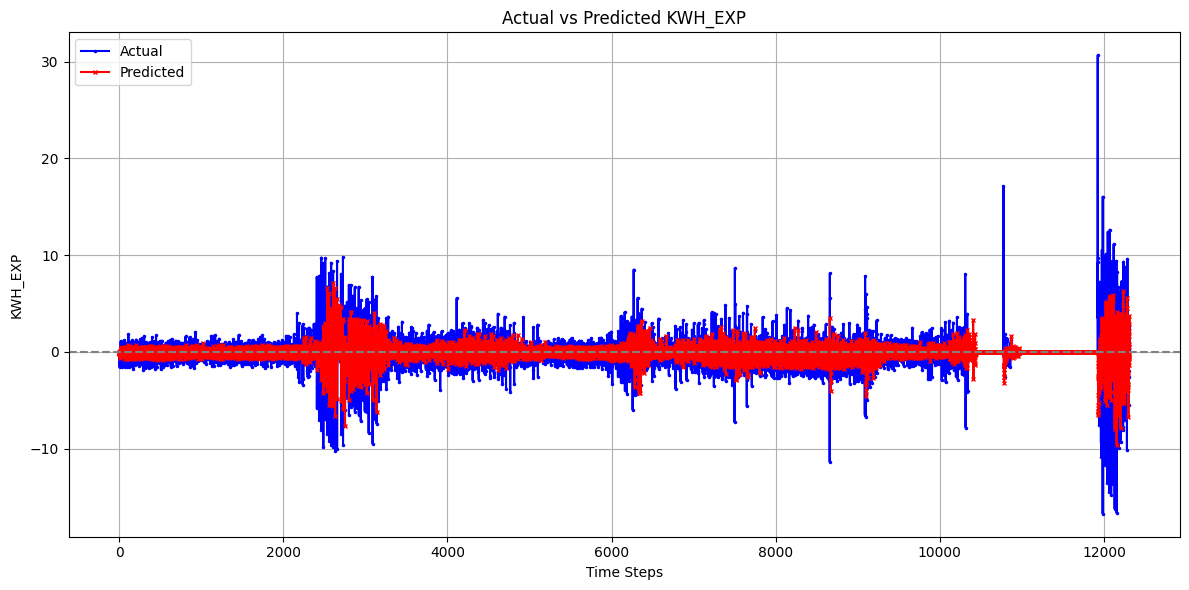

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Garis referensi
plt.title('Actual vs Predicted KWH_EXP')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [14]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 1.1443922773677786
MAE: 0.46425880305087525
R2: 0.2566655100988794
MAPE: 32569956902137.473


# ATTENTION

In [15]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(units=128, return_sequences=True)(inputs)
x = AttentionLayer()(x)
x = LSTM(units=64, return_sequences=False)(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 96, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.6952 - val_loss: 1.8094 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.4534 - val_loss: 1.7413 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3790 - val_loss: 1.7204 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3134 - val_loss: 1.6945 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2963 - val_loss: 1.7175 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3102 - val_loss: 1.7010 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2403 - val_loss: 1.6620 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1391 - val_loss: 1.6679 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1503 - val_loss: 1.6391 - learning_rate: 6.703

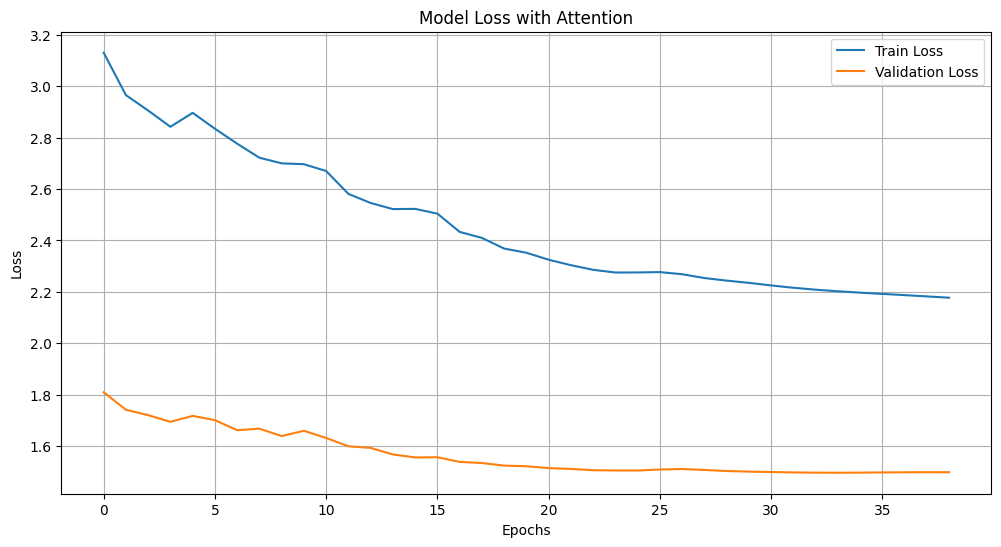

385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [16]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

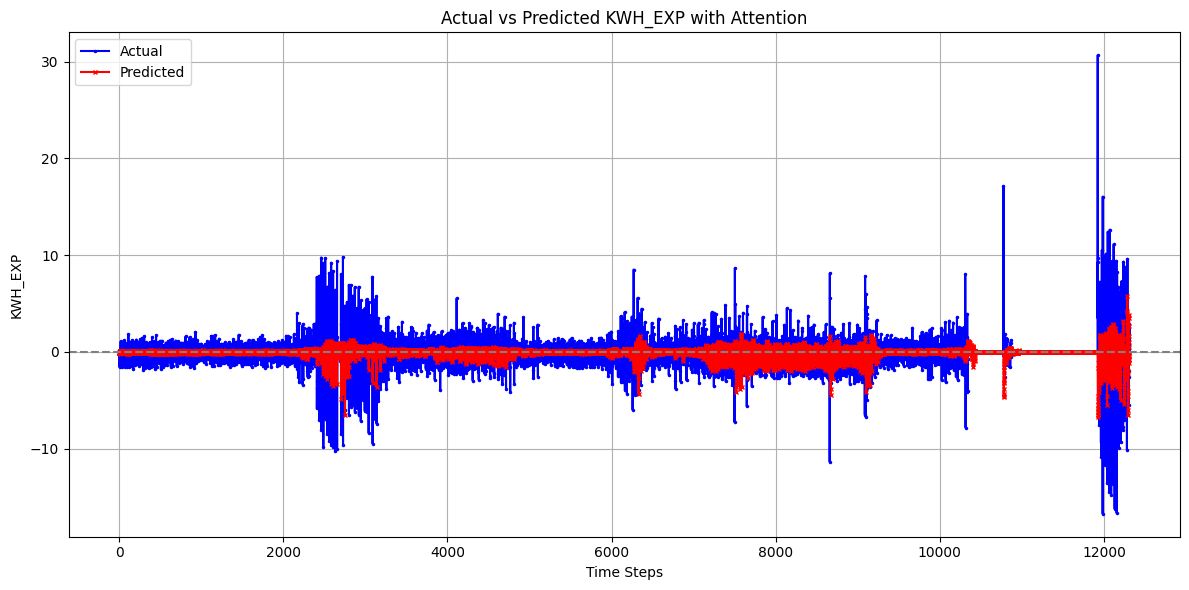

In [17]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 1.4173637205566008
MAE: 0.5129697900936695
R²: 0.07935822439519757
MAPE: 34876019333683.617


BILSTM ATTENTION

In [19]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 96, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 3.3526 - val_loss: 1.5617 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.8322 - val_loss: 1.5053 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.7752 - val_loss: 1.5469 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.7215 - val_loss: 1.5290 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.6293 - val_loss: 1.5027 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.5588 - val_loss: 1.4891 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.5084 - val_loss: 1.4822 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4718 - val_loss: 1.4601 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4361 - val_loss: 1.4466 - learning_rate: 6.703

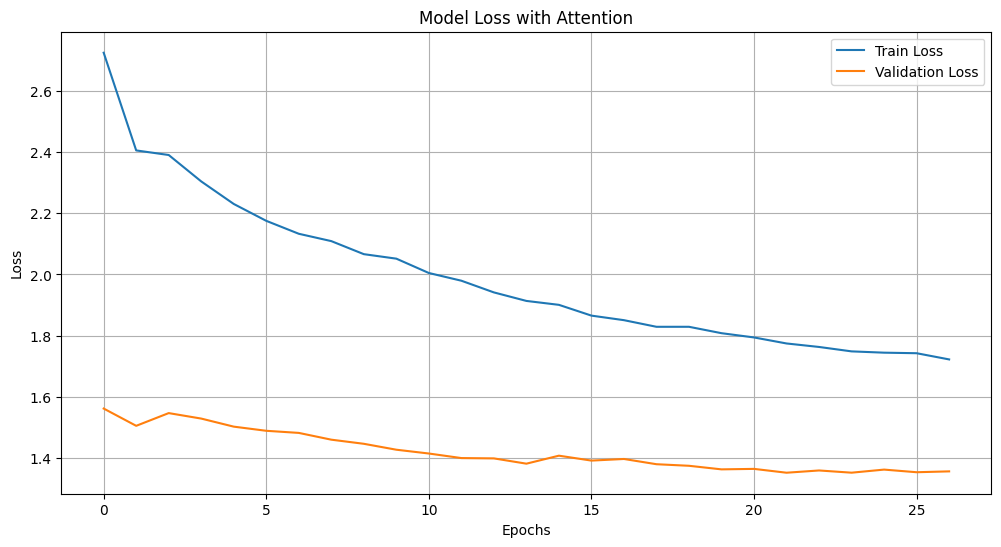

385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [20]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

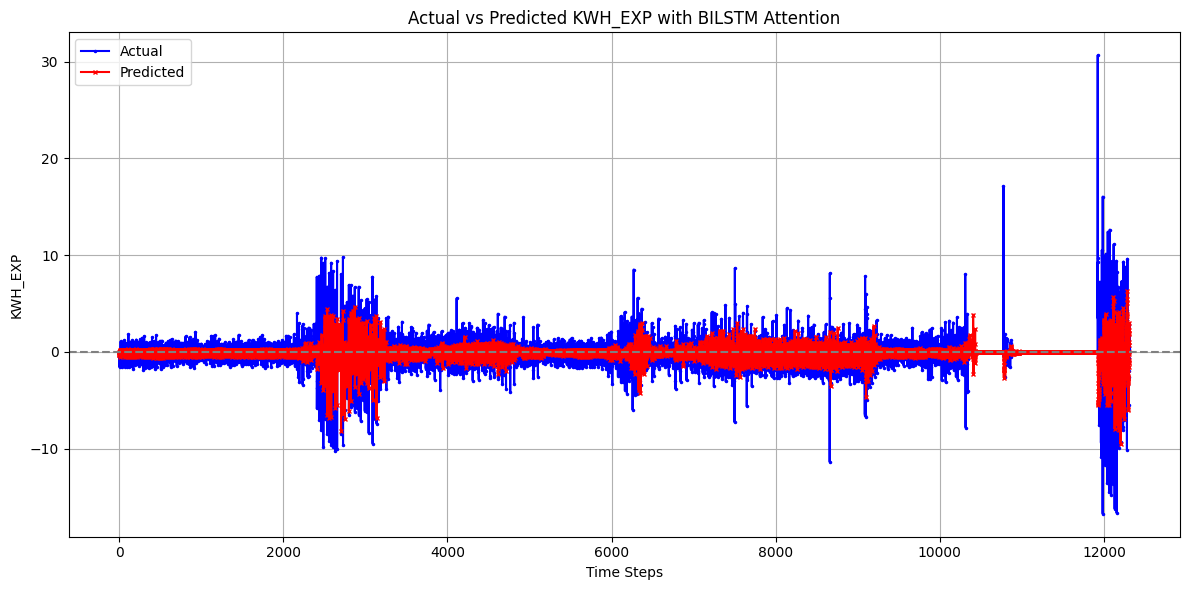

In [21]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with BILSTM Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 1.179654167665815
MAE: 0.49054517270223946
R²: 0.23376131915315823
MAPE: 41921851817398.18


# LSTM

In [23]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 96, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 2.2283 - val_loss: 1.4145 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.2003 - val_loss: 1.3858 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.1331 - val_loss: 1.3928 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.1762 - val_loss: 1.4031 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.2116 - val_loss: 1.3851 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.1766 - val_loss: 1.3746 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.1420 - val_loss: 1.3771 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.1077 - val_loss: 1.3610 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.0752 - val_loss: 1.3577 - learning_rate: 6.703

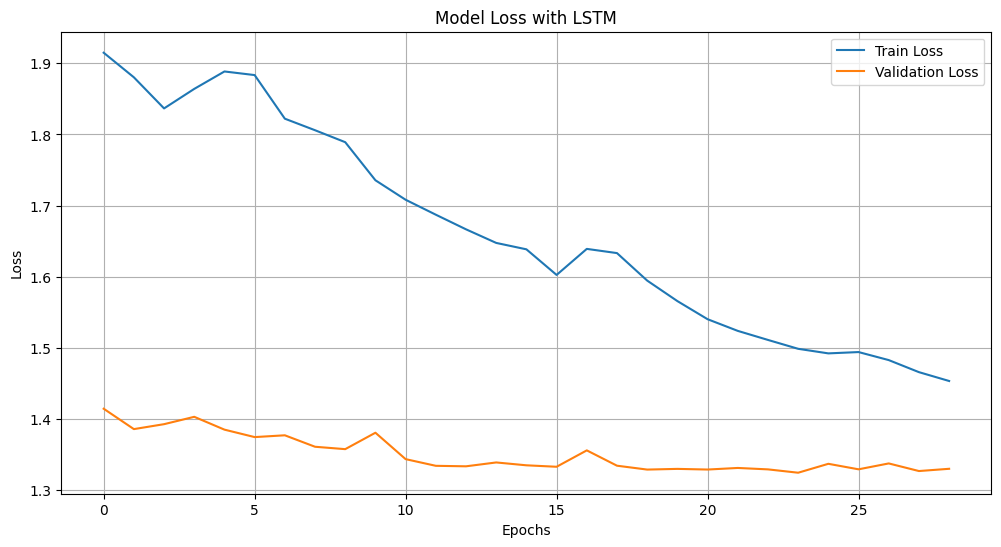

385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [24]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

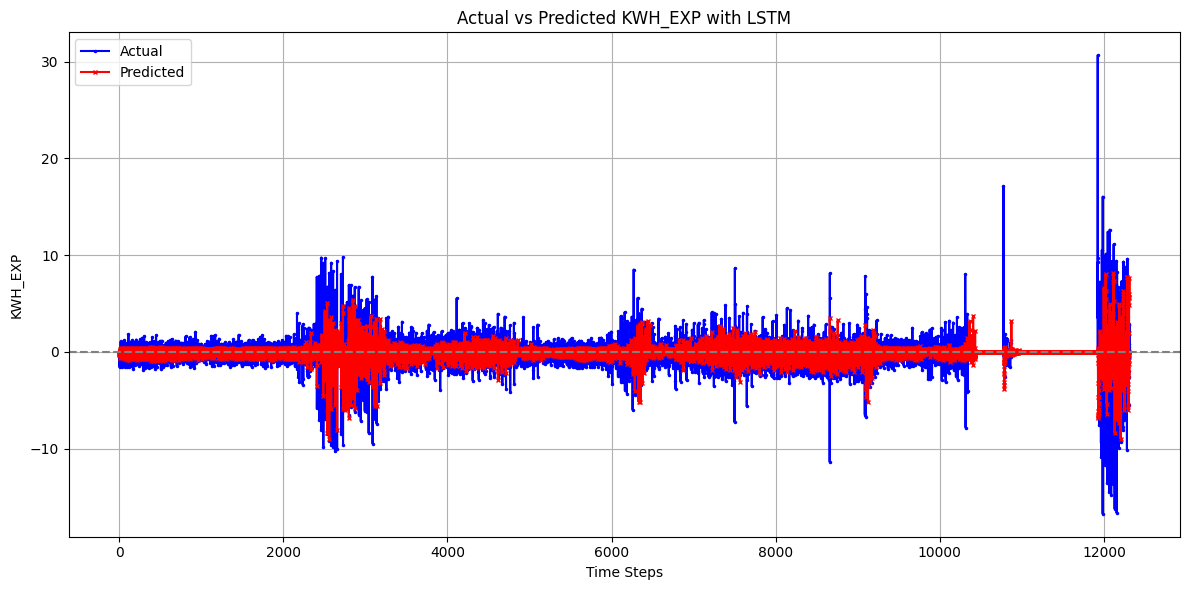

In [25]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [26]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 1.2027248195687639
MAE: 0.4839274878809863
R²: 0.21877588836765016
MAPE: 36216515198220.16
